In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import heapq as pq


# KNN Implementation Using KD-TREE

In [10]:
class Node:
    '''
        A utility class to represent a k-d tree node.
        Attributes:
            key: The 2D point at this node. 
            left: The left child node.
            right: The right child node.
    '''

    def __init__(self, key, left=None, right=None):
        self.key = key
        self.left = left
        self.right = right


class KDTree():
    def get_distance(self, a, b):
        '''
            Calculates square of the euclidean distance between two points. 
            Parameters:
                a: The first point.
                b: The second point.
            Returns:
                The square of the euclidean distance between the two points.
        '''
        #return (a[0]-b[0])**2+(a[1]-b[1])**2
        return abs(a[0]-b[0])+abs(a[1]-b[1])

    def __init__(self):
        self.points = []

    def build(self, points, dimension=0):
        '''
            Builds a k-d tree from a list of points.
            Parameters:
                points: The list of points.
                dimension: The current dimension being considered.
            Returns:
                The root node of the k-d tree.
        '''
        if(len(points) == 1):
            # leaf node of the tree
            return Node(points[0])
        elif len(points) > 1:
            # Sort the points based on the current dimension.
            points.sort(key=lambda x: x[0][dimension])
            # Find the median point for a balanced tree.
            median = len(points) >> 1
            new_dimension = (dimension+1) % 2
            return Node(points[median],
                        self.build(points[:median], new_dimension),
                        self.build(points[median+1:], new_dimension))

    def fit(self, X, y):
        '''
            Builds a k-d tree from a list of points.
            Parameters:
                points: The list of points.
            Returns:
                None 
        '''
        for a, b in zip(X, y):
            self.points.append(((a[0], a[1]), b))
        self.head = self.build(self.points)

    def bfs(self):
        '''
            Performs a breadth-first search on the k-d tree.
        '''
        q = deque()
        q.append((self.head, 0))
        while len(q):
            u = q.popleft()
            print(u[0].key, u[1])
            if u[0].left is not None:
                q.append((u[0].left, u[1]+1))
            if u[0].right is not None:
                q.append((u[0].right, u[1]+1))

    def dfs(self, root, point, dimension, heap, K):
        '''
            Performs a depth-first search on the k-d tree to find the K nearest neighbors of a point.
            Inspiration 1: https://stackoverflow.com/questions/34688977/how-do-i-traverse-a-kdtree-to-find-k-nearest-neighbors
            Inspiration 2: https://github.com/Vectorized/Python-KD-Tree/blob/master/kd_tree.py
            Parameters:
                root: The current node of the k-d tree.
                point: The point to find the K nearest neighbors of.
                dimension: The current dimension being considered.
                heap: The heap of nearest neighbors.
                K: The number of nearest neighbors to consider.
            Returns:
                The heap of nearest neighbors.

        '''
        if root is not None:
            radius = root.key[0][dimension]-point[dimension]
            actual_distance = self.get_distance(root.key[0], point)
            if len(heap) < K:
                # We take the point as the heap is not full yet.
                pq.heappush(heap, (-actual_distance, root.key))
            elif actual_distance < -heap[0][0]:
                # Current root is closer than the furthest point in heap.
                pq.heappushpop(heap, (-actual_distance, root.key))
            dimension = (dimension+1) % 2
            # Magic line from Inspiration 2. Here We first check if the point is in the left subtree or the right subtree.
            # We first traverse the appropriate subtree. The second subtree will only be traversed if there's a chance of
            # finding a new neighbor.
            # If the heap is not full it will surely traverse the other subtree as radius**2>= -heap[0][0]
            # Otherwise the condition will be checked.
            for b in (radius < 0, radius >= 0)[:1+(radius**2 < -(heap[0][0]))]:
                if b == False:
                    self.dfs(root.left, point, dimension, heap, K)
                else:
                    self.dfs(root.right, point, dimension, heap, K)
        return heap

    def predict(self, point, K):
        '''
            Predicts the class of a point using the k-d tree.
            Parameters:
                point: The point to predict the class of.
                K: The number of nearest neighbors to consider.
        '''
        heap = []
        neighbors = self.dfs(self.head, point, 0, heap, K)
        frequency = dict()
        for item in neighbors:
            frequency[item[1][1]] = frequency.get(item[1][1], 0) + 1
        max_frequnecy = max(frequency, key=frequency.get)
        return max_frequnecy


# Using diabetes dataset and taking blood pressure and Age as features.

In [11]:

dataset = pd.read_csv('./diabetes.csv')
X = dataset.iloc[:50, [2, 7]].values
y = dataset.iloc[:50, 8].values
knn = KDTree()
knn.fit(X, y)
#knn.bfs()
# input point
in_x = 70
in_y = 20
#in_x, in_y = map(int, input("Enter Point(x,y):").split())
K = 9# int(input("How many Nearest Values:"))
output = knn.predict((in_x, in_y), K)


# Visualization of the data for better Understanding

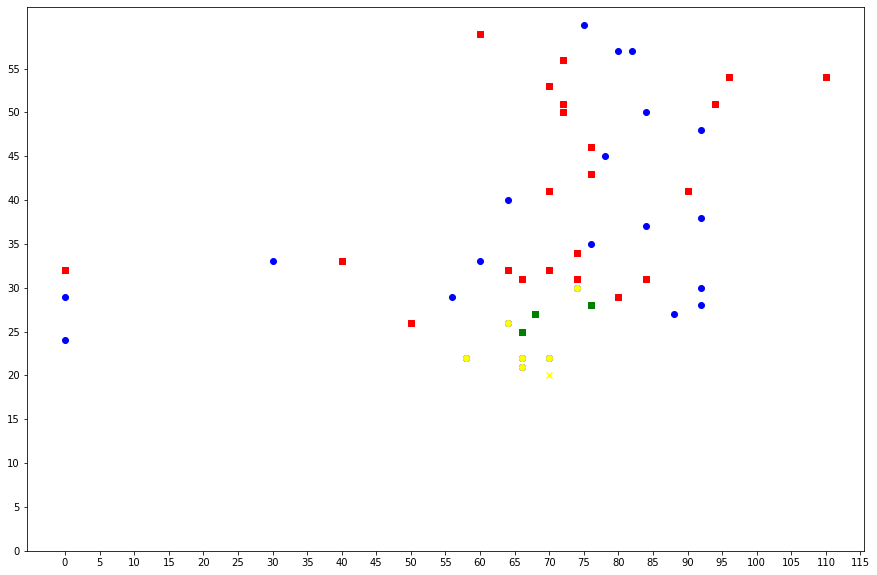

In [12]:


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
for (feature, target) in knn.points:
    plt.scatter(feature[0], feature[1], marker='s' if target ==
                1 else 'o', color='red' if target == 1 else 'blue')
heap = []
neighbors = knn.dfs(knn.head, (in_x, in_y), 0, heap, K)
for (distance, (feature, target)) in neighbors:
    plt.scatter(feature[0], feature[1], marker='s' if target ==
                1 else 'o', color='green' if target == 1 else 'yellow')
plt.scatter(in_x, in_y, color='green' if output == 1 else 'yellow', marker='x')
plt.xticks(np.arange(0, 120, 5.0))
plt.yticks(np.arange(0, 60, 5.0))
plt.show()
